# Model A: Baseline model

Importing libraries we will use, nump,y pandas, scikit-learn models and metrics, etc...

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.simplefilter(action='ignore')

seed = 42
np.random.seed(seed)

In [2]:
# We will use these metrics to check our model performance

metrics = [
    ('Precision', precision_score, False),
    ('Recall', recall_score, False),
#     ('MCC', matthews_corrcoef, False),
#     ('F1', f1_score, False),
     ('ROC-AUC', roc_auc_score, True)
]

## Load dataset: Binary classification

Load data from Google Cloud Storage.

In [3]:
train = pd.read_csv('gs://home-credit-simonyi-workshop/input/application_train.subsample.csv')
#train = pd.read_csv('input/application_train.csv')

train.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,187009,316796,0,Cash loans,M,Y,Y,0,90000.0,263686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,74613,186528,0,Cash loans,F,N,N,0,121500.0,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
2,175379,303231,0,Cash loans,F,N,Y,0,180000.0,742500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
3,71072,182429,0,Cash loans,M,N,Y,1,180000.0,188478.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,12.0
4,532,100614,0,Revolving loans,F,N,N,0,90000.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


This is a huge dataset with lots of features, for now we will use only 6 features + the target variable.

In [4]:
target = 'TARGET'

features = [
    'DAYS_EMPLOYED',
    'DAYS_BIRTH',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'CNT_FAM_MEMBERS',
    'AMT_ANNUITY',
]

for f in features:
    train.loc[train[f] == np.inf, f] = np.nan
    train[f] = train[f].dropna()

na_mask = train[features].isna().any(axis=1)

X = train.loc[~na_mask, features]
y = train.loc[~na_mask, target]

print("Train features DataFrame shape:", X.shape)
print("Train target Series shape:", y.shape)

Train features DataFrame shape: (2000, 6)
Train target Series shape: (2000,)


## Train-test split

We are splitting out dataset into **train** and **validate** sets. We will use the train dataset to train our models, and the validate dataset, to check our results. 

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

print('Train features shape: ', X_train.shape)
print('Train target shape: ', y_train.shape)
print('Validate features shape: ', X_valid.shape)
print('Validate target shape: ', y_valid.shape)

Train features shape:  (1600, 6)
Train target shape:  (1600,)
Validate features shape:  (400, 6)
Validate target shape:  (400,)


## Train the model

We use RandomForestClassifier as our model.

In [27]:
model = RandomForestClassifier(n_estimators=10, random_state=seed, max_depth=2);
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Check prediction performance on train dataset.

In [28]:
pred_train = model.predict(X_train)
proba_train = model.predict_proba(X_train)[:,1]

for m in metrics:
    score = m[1](y_train, proba_train) if m[2] else m[1](y_train, pred_train)
    print('%s on train: %.3f' % (m[0], score))

Precision on train: 0.000
Recall on train: 0.000
ROC-AUC on train: 0.709


Of course it is close to perfect, but this is expected. But let's check out model on new data!

## Evaluate model

In [29]:
pred_valid = model.predict(X_valid)
proba_valid = model.predict_proba(X_valid)[:,1]

In [30]:
for m in metrics:
    score = m[1](y_valid, proba_valid) if m[2] else m[1](y_valid, pred_valid)
    print('%s on CV: %.3f' % (m[0], score))

Precision on CV: 0.000
Recall on CV: 0.000
ROC-AUC on CV: 0.572


## Visualize precision-recall tradeoff

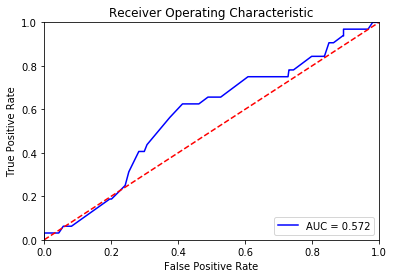

In [31]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt

# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_valid)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_valid, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()